In [97]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
import os
from glob import glob
#from nrcatalogtools.waveform import WaveformModes
import pandas as pd
import ast
import numpy as np
import pylab as plt
from lal import MTSUN_SI
import deepdish as dd
import fnmatch
import csv

In [98]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/sims_from_Prayush_Vaishak'
#category = 'ICTSEccParallel'
#category = 'EccContPrecDiff'
category = 'EccPrecDiff'
levs = ['Lev2', 'Lev3']
sims = next(os.walk(os.path.join(base_dir, category)))[1]
sims.sort()

## Read metadata

In [99]:
table_metadata0 = pd.read_csv(os.path.join(base_dir, category, category+'_ref_time.csv'))
table_metadata0 = table_metadata0.set_index('SimulationAlias').T

rows_to_drop = [row for row in table_metadata0.T.keys() if row in ['Status', 'RequestedReferenceTime', 'ReferenceTime', 'Ncycles(2,2)', 'IDType', 'Sl.No.']]
table_metadata0 = table_metadata0.drop(rows_to_drop)

Ncycles_dict = {}
for sim in table_metadata0.keys():
    Ncycles_dict[sim] = {}
    temp_dict = eval(table_metadata0[sim]['Ncycles'])
    for lev_num in temp_dict.keys():
        Ncycles_dict[sim][f'Ncycles_Lev{lev_num}'] = temp_dict[lev_num]

table_metadata0 = pd.concat([table_metadata0, pd.DataFrame(Ncycles_dict)])
table_metadata0 = table_metadata0.drop('Ncycles')
table_metadata0

,EccPrecDiff001,EccPrecDiff002,EccPrecDiff003,EccPrecDiff003a,eccprecrun4b
ReqRefTime,730.0,730.0,NaN,NaN,330.0
Omega0,0.014599,0.014599,0.01906,0.01906,0.01906
Omega_ref,0.00167,0.00167,NaN,NaN,0.00429
D0,18.0,18.0,11.0,11.0,14.4
MassRatio,1,1,2,2,2
Eccentricity,0.1,0.1,0.25,NaN,NaN
ChiA,"(0.0,0.2,0.2)","(0.0,0.2,0.2)","(0.1,0.1,0.2)","(0.1,0.1,0.2)","(0.1,0.1,0.2)"
ChiA_ref,"(-0.02181,0.19931,0.1995)","(-0.02181,0.19931,0.1995)",NaN,NaN,"(0.08876,0.10947,0.20035)"
ChiB,"(0.2,0.0,0.2)","(0.2,0.0,0.2)","(0.3,0.0,0.3)","(0.3,0.0,0.3)","(0.3,0.0,0.3)"
ChiB_ref,"(0.19885,0.02167,0.19997)","(0.19885,0.02167,0.19996)",NaN,NaN,"(0.29346,0.05178,0.30195)"


## Get sim status

In [100]:
status_file = os.path.join(base_dir, 'nrsimulations', 'SimulationStatus.md')
with open(status_file) as f:
    status_text = f.read().splitlines()

while(1):
    try:
        status_text.remove('')
    except ValueError:
        break

In [101]:
status_lines = {}
for line, idx in zip(status_text, range(len(status_text))):
    if '###' in line or ':' in line:
        continue
    elif '##' in line:
        cat_key = ''.join(line.split('##')[-1].split())
        status_lines[cat_key] = []
    elif '#' in line:
        continue
    else:
        try:
            #metadata_lines.append(','.join([''.join(element.split()) for element in line.split('|') if element!='' and element.split()!=[]]))
            words = []
            for element in line.split('|')[:-2]: # Removing the Allocation column
                if element!='' and element.split()!=[]:
                    if '(' in element or ')' in element:
                        element = '\"%s\"'%element
                    words.append(''.join(element.split()))
            status_lines[cat_key].append(words)
            #metadata_lines[cat_key].append(','.join(words))
        except IndexError:
            print(line,'\n',idx,'\n')
            break

# Converting it to a dictionary of pandas dataframes
for cat_key in status_lines.keys():
    status_lines[cat_key] = pd.DataFrame(status_lines[cat_key][1:], 
                                         columns=['Sim ID']+status_lines[cat_key][0])
    status_lines[cat_key].drop(columns=['Segment', 'Comment'], inplace=True)

status_lines = status_lines[category].set_index('Sim ID').T

In [102]:
sims_status = {}
for sim in table_metadata0.keys():
    sims_status[sim] = {}
for key in status_lines:
    sim, lev = key.split('_')
    sims_status[sim]['Status_'+lev] = status_lines[key]['Status']

table_metadata = pd.concat([table_metadata0, pd.DataFrame(sims_status)])
table_metadata

,EccPrecDiff001,EccPrecDiff002,EccPrecDiff003,EccPrecDiff003a,eccprecrun4b
ReqRefTime,730.0,730.0,NaN,NaN,330.0
Omega0,0.014599,0.014599,0.01906,0.01906,0.01906
Omega_ref,0.00167,0.00167,NaN,NaN,0.00429
D0,18.0,18.0,11.0,11.0,14.4
MassRatio,1,1,2,2,2
Eccentricity,0.1,0.1,0.25,NaN,NaN
ChiA,"(0.0,0.2,0.2)","(0.0,0.2,0.2)","(0.1,0.1,0.2)","(0.1,0.1,0.2)","(0.1,0.1,0.2)"
ChiA_ref,"(-0.02181,0.19931,0.1995)","(-0.02181,0.19931,0.1995)",NaN,NaN,"(0.08876,0.10947,0.20035)"
ChiB,"(0.2,0.0,0.2)","(0.2,0.0,0.2)","(0.3,0.0,0.3)","(0.3,0.0,0.3)","(0.3,0.0,0.3)"
ChiB_ref,"(0.19885,0.02167,0.19997)","(0.19885,0.02167,0.19996)",NaN,NaN,"(0.29346,0.05178,0.30195)"


## Get .h5 file paths

In [103]:
def find_file_with_max_N(files):
    N_list = []
        
    for file in files:
        N = int(file.split('Extrapolated_')[-1].split('_')[0].split('N')[-1])
        N_list.append(N)
    
    N_max = max(N_list)
    for file in files:
        if '_N%s_CoM'%N_max in file:
            return(file)

In [104]:
def find_dir_with_max_Lev(dirs):
    Lev_list = []
    for my_dir in dirs:
        Lev = int(my_dir.split('waveforms_')[-1].split('Lev')[-1])
        Lev_list.append(Lev)
    Lev_list.sort(reverse=True)
    
    Lev_max = max(Lev_list)
    for my_dir in dirs:
        if '_Lev%s'%Lev_max in my_dir:
            return(Lev_list, my_dir)

In [105]:
sim_h5_files = {}
available_sim_names = {}
skipped_sims = {}

for lev in levs:
    sim_h5_files[lev] = []
    available_sim_names[lev] = []
    skipped_sims[lev] = []
    
#skipped sims from Vaishak ['11', '15', '09_Lev2', '16_Lev3']
#sims_will_be_there = ['13_Lev2', '09_Lev3']

for sim_name in sims:
    print(sim_name)
    #print('\n')
    ex_flag, ex_found, CoM_flag, Lev_in_sim_name = 1, 0, 1, 0
    if 'Lev' in sim_name:
        Lev_in_sim_name = 1
        sim_dir = os.path.join(base_dir, category, sim_name)
        Lev_list = [int(sim_name.split('Lev')[-1][0])]
    else:
        sim_dirs = next(os.walk(glob(os.path.join(base_dir, category, sim_name))[0]))[1]
        Lev_list, max_lev_dir = find_dir_with_max_Lev(sim_dirs)
        
    for Lev in Lev_list:
        if Lev_in_sim_name:
            pass
        else:
            sim_dir = os.path.join(base_dir, category, sim_name, 
                                   max_lev_dir.replace(f'Lev{max(Lev_list)}', f'Lev{Lev}'))
            
        if os.path.isdir(os.path.join(sim_dir, 'extrapolated')) == False:
            print(sim_name, f'- Lev{Lev} has no directory for extrapolated waveforms.')
            if Lev == Lev_list[-1]:
                if ex_found == 0:
                    print("No directory for extrapolated waveforms found.")
                else:
                    print(f"No level lower than Lev{Lev}")
                ex_flag = 404
                continue
            else:
                print("Continuing to next Lev.")
                continue
        else:
            ex_found = 1
        
        files = glob(os.path.join(sim_dir, 'extrapolated', '*CoM.h5'))
        if files == []:
            print("No file with CoM found for", sim_name, f'- Lev{Lev}.')
            if Lev == Lev_list[-1]:
                print("No CoM file found.")
                CoM_flag = 404
            else:
                print("Continuing to next Lev.")
            continue
        if ex_flag == 1 and CoM_flag == 1:
            if Lev == max(Lev_list):
                #print("Using max Lev for", sim_name)
                pass
            else:
                print(f"Using Lev{Lev} for {sim_name}")
            break
    if ex_flag == 404 or CoM_flag == 404 or sims_status[sim_name.split('_')[0]]['Status_'+sim_name.split('_')[-1]] != 'Completed':
        print(f'Skipping {sim_name} entirely\n')
        skipped_sims[sim_name.split('_')[-1]].append(sim_name.split('_')[0])
        continue
    else:
        file = find_file_with_max_N(files)
    sim_h5_files[sim_name.split('_')[-1]].append(file)
    available_sim_names[sim_name.split('_')[-1]].append(sim_name.split('_')[0])

EccPrecDiff001_waveforms_Lev2
EccPrecDiff001_waveforms_Lev3
EccPrecDiff001_waveforms_Lev3 - Lev3 has no directory for extrapolated waveforms.
No directory for extrapolated waveforms found.
Skipping EccPrecDiff001_waveforms_Lev3 entirely

EccPrecDiff002_waveforms_Lev2
EccPrecDiff002_waveforms_Lev3
eccprecrun4b_waveforms_Lev3


In [106]:
skipped_sims

{'Lev2': [], 'Lev3': ['EccPrecDiff001']}

In [107]:
available_sim_names

{'Lev2': ['EccPrecDiff001', 'EccPrecDiff002'],
 'Lev3': ['EccPrecDiff002', 'eccprecrun4b']}

## Define which $(\ell, |m|)$ modes to extract

In [108]:
modes = []
for l in range(2,6):
    for m in [l, -l, l-1, -(l-1)]:
        modes.append([l,m])
print(modes)

[[2, 2], [2, -2], [2, 1], [2, -1], [3, 3], [3, -3], [3, 2], [3, -2], [4, 4], [4, -4], [4, 3], [4, -3], [5, 5], [5, -5], [5, 4], [5, -4]]


## Combine the available sims into one file

In [109]:
table_metadata

,EccPrecDiff001,EccPrecDiff002,EccPrecDiff003,EccPrecDiff003a,eccprecrun4b
ReqRefTime,730.0,730.0,NaN,NaN,330.0
Omega0,0.014599,0.014599,0.01906,0.01906,0.01906
Omega_ref,0.00167,0.00167,NaN,NaN,0.00429
D0,18.0,18.0,11.0,11.0,14.4
MassRatio,1,1,2,2,2
Eccentricity,0.1,0.1,0.25,NaN,NaN
ChiA,"(0.0,0.2,0.2)","(0.0,0.2,0.2)","(0.1,0.1,0.2)","(0.1,0.1,0.2)","(0.1,0.1,0.2)"
ChiA_ref,"(-0.02181,0.19931,0.1995)","(-0.02181,0.19931,0.1995)",NaN,NaN,"(0.08876,0.10947,0.20035)"
ChiB,"(0.2,0.0,0.2)","(0.2,0.0,0.2)","(0.3,0.0,0.3)","(0.3,0.0,0.3)","(0.3,0.0,0.3)"
ChiB_ref,"(0.19885,0.02167,0.19997)","(0.19885,0.02167,0.19996)",NaN,NaN,"(0.29346,0.05178,0.30195)"


In [110]:
sim_dict_modes = {}
for lev in levs:
    print('\nRunning', lev)
    sim_dict_modes[lev] = {}
    
    for mode in modes:
        l, m = mode
        print('Running', mode)
        sim_dict = {}
        for sim in available_sim_names[lev]:
            sim_dict[sim] = {}
            for key in list(table_metadata[sim].keys()):
                if '(' in str(table_metadata[sim][key]):
                    chix, chiy, chiz = eval(table_metadata[sim][key])
                    sim_dict[sim][key+'_x'] = np.array([float(chix)])
                    sim_dict[sim][key+'_y'] = np.array([float(chiy)])
                    sim_dict[sim][key+'_z'] = np.array([float(chiz)])
                
                elif key=='IDType' or pd.isna(table_metadata[sim][key]):
                    continue
                elif 'Lev' in key:
                    if key==lev:
                        if table_metadata[sim][key] == 'Completed':
                            sim_dict[sim][key] = np.array([float(1)])
                        else:
                            sim_dict[sim][key] = np.array([float(0)])
                    else:
                        continue
                else:
                    sim_dict[sim][key] = np.array([float(table_metadata[sim][key])])
    
            sim_dict[sim]['x0'] = np.array([table_metadata[sim]['Omega0']**(2/3)])
            sim_dict[sim]['x_ref'] = np.array([table_metadata[sim]['Omega_ref']**(2/3)])
            
            with h5py.File([file for file in sim_h5_files[lev] if sim in file][0], 'r') as f:
                t, Re_ht, Im_ht = f['Y_l%s_m%s.dat'%(mode[0], mode[1])][:].T
                f.close()
            sim_dict[sim]['t_by_M'] = t
            sim_dict[sim]['Real_rh_by_M'] = Re_ht
            sim_dict[sim]['Imag_rh_by_M'] = Im_ht
        sim_dict_modes[lev]['%s%s'%(l, m)] = sim_dict
print('Done')


Running Lev2
Running [2, 2]
Running [2, -2]
Running [2, 1]
Running [2, -1]
Running [3, 3]
Running [3, -3]
Running [3, 2]
Running [3, -2]
Running [4, 4]
Running [4, -4]
Running [4, 3]
Running [4, -3]
Running [5, 5]
Running [5, -5]
Running [5, 4]
Running [5, -4]

Running Lev3
Running [2, 2]
Running [2, -2]
Running [2, 1]
Running [2, -1]
Running [3, 3]
Running [3, -3]
Running [3, 2]
Running [3, -2]
Running [4, 4]
Running [4, -4]
Running [4, 3]
Running [4, -3]
Running [5, 5]
Running [5, -5]
Running [5, 4]
Running [5, -4]
Done


EccPrecDiff001 - Lev2 Status: Completed


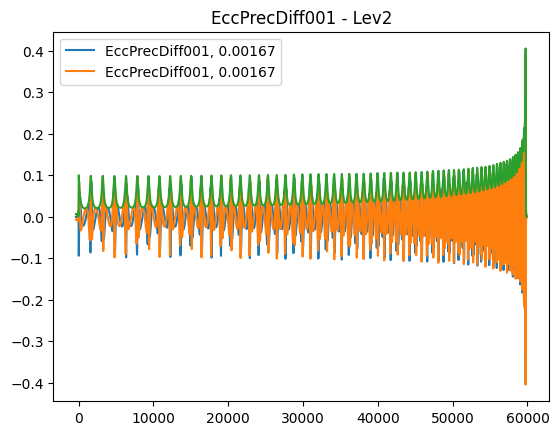

EccPrecDiff002 - Lev2 Status: Completed


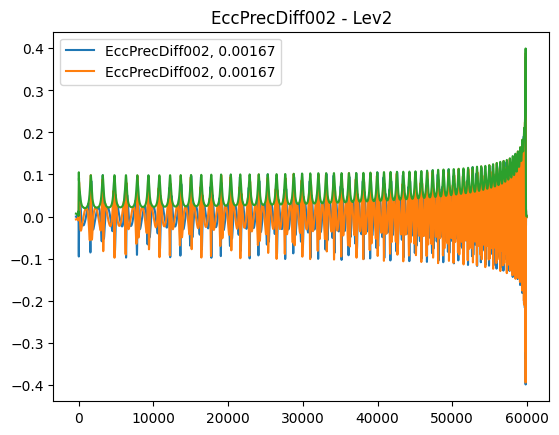

EccPrecDiff002 - Lev3 Status: Completed


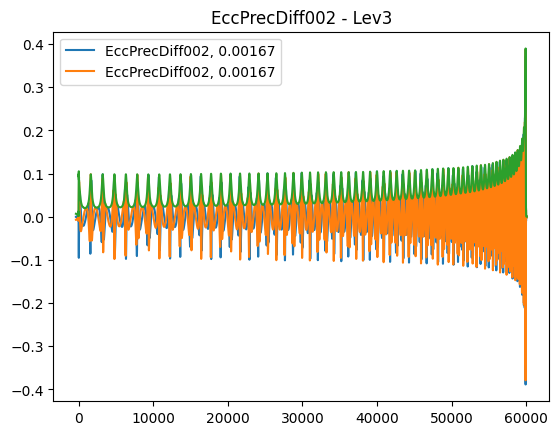

eccprecrun4b - Lev3 Status: Completed


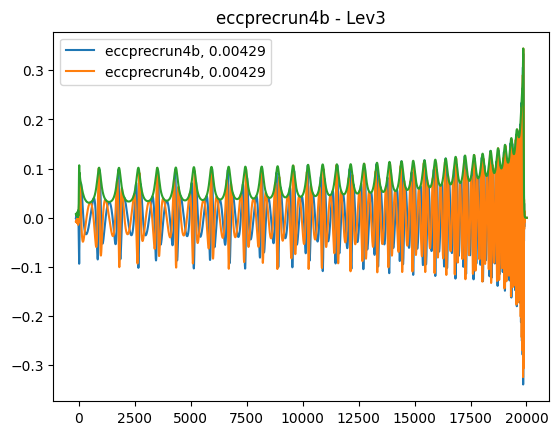

In [111]:
for lev in levs:
    for sim in available_sim_names[lev]:
        print(f"{sim} - {lev} Status: {sims_status[sim]['Status_'+lev]}")
        plt.figure()
        Omega_ref = sim_dict_modes[lev]['22'][sim]['Omega_ref']
        plt.plot(sim_dict_modes[lev]['22'][sim]['t_by_M'], 
                 sim_dict_modes[lev]['22'][sim]['Real_rh_by_M'], label='{}, {}'.format(sim, Omega_ref[0]))
        plt.plot(sim_dict_modes[lev]['22'][sim]['t_by_M'], 
                 sim_dict_modes[lev]['22'][sim]['Imag_rh_by_M'], label='{}, {}'.format(sim, Omega_ref[0]))
        plt.plot(sim_dict_modes[lev]['22'][sim]['t_by_M'], 
                 np.sqrt(sim_dict_modes[lev]['22'][sim]['Real_rh_by_M']**2+sim_dict_modes[lev]['22'][sim]['Imag_rh_by_M']**2))
        plt.title(f'{sim} - {lev}')
        plt.legend()
        plt.show()
        plt.close()
#plt.plot(sim_dict_modes['22']['eccprecrun4b']['t_by_M'], 
#         sim_dict_modes['22']['eccprecrun4b']['Real_rh_by_M'])

### Remove sims whose plots look weird

In [16]:
weird_sims = {'Lev3': ['ICTSEccParallel14']}

In [17]:
sim_dict_modes['Lev3']['22']['ICTSEccParallel14']

{'Omega0': array([0.0125772]),
 'adot0': array([-0.00072104]),
 'D0': array([17.1103]),
 'MassRatio': array([9.5]),
 'ChiA_x': array([0.]),
 'ChiA_y': array([0.]),
 'ChiA_z': array([-0.6]),
 'ChiB_x': array([0.]),
 'ChiB_y': array([0.]),
 'ChiB_z': array([-0.3]),
 'SemiMajorAxis': array([16.]),
 'Eccentricity': array([0.1]),
 'AnomalyAngle': array([4.]),
 'ZwickyDays': array([0.]),
 'ChiEff': array([-0.571429]),
 'ChiPrec': array([0.]),
 'ReqRefTime': array([338.]),
 'Omega_ref': array([0.01595]),
 'ChiA_ref_x': array([0.]),
 'ChiA_ref_y': array([0.]),
 'ChiA_ref_z': array([-0.60001]),
 'ChiB_ref_x': array([0.]),
 'ChiB_ref_y': array([0.]),
 'ChiB_ref_z': array([-0.29998]),
 'MA_ref': array([0.944598]),
 'MB_ref': array([0.0963046]),
 'x0': array([0.0540824]),
 'x_ref': array([0.06336369]),
 't_by_M': array([-178.08548115, -177.32703024, -176.56857933, ..., 9030.68967301,
        9030.78967109, 9030.88966918], shape=(23270,)),
 'Real_rh_by_M': array([-4.90627721e-04, -4.81690424e-04, -

In [18]:
for lev in weird_sims.keys():
    for sim in weird_sims[lev]:
        for mode in sim_dict_modes[lev]:
            del(sim_dict_modes[lev][mode][sim])

#### Check that it no longer exists in data

In [19]:
sim_dict_modes['Lev3']['22']['ICTSEccParallel14']

KeyError: 'ICTSEccParallel14'

## Include simulation complete/incomplete info in dict

##### Introduce a flag which says in the file whether the sim is complete or not

In [70]:
for lev in levs:
    for sim_name in sim_dict_modes[lev]['22'].keys():
        amp = np.sqrt(sim_dict_modes[lev]['22'][sim_name]['Real_rh_by_M']**2+sim_dict_modes[lev]['22'][sim_name]['Imag_rh_by_M']**2)
        print('\n',sim_name, lev, amp[-1])
        for mode in sim_dict_modes[lev].keys():
            if amp[-1]<2e-4:
                sim_dict_modes[lev][mode][sim_name]['Complete'] = np.array([1])
            else:
                if mode=='22':
                    print('Incomplete simulation!')
                sim_dict_modes[lev][mode][sim_name]['Complete'] = np.array([0])


 EccPrecDiff001 Lev2 5.777212947044284e-06

 EccPrecDiff002 Lev2 2.6233965098169706e-06

 EccPrecDiff002 Lev3 4.467428468338478e-06

 eccprecrun4b Lev3 8.321979343252165e-06


### Export dictionary to h5 file

In [71]:
for lev in levs:
    print('\n', lev)
    for mode in modes:
        print(mode)
        l,m = mode
        dd.io.save(os.path.join(base_dir, category, 
                                f'{category}_{lev}_data_{l}{m}_mode.h5'), 
                                sim_dict_modes[lev][f'{l}{m}'])


 Lev2
[2, 2]
[2, -2]
[2, 1]
[2, -1]
[3, 3]
[3, -3]
[3, 2]
[3, -2]
[4, 4]
[4, -4]
[4, 3]
[4, -3]
[5, 5]
[5, -5]
[5, 4]
[5, -4]

 Lev3
[2, 2]
[2, -2]
[2, 1]
[2, -1]
[3, 3]
[3, -3]
[3, 2]
[3, -2]
[4, 4]
[4, -4]
[4, 3]
[4, -3]
[5, 5]
[5, -5]
[5, 4]
[5, -4]


## Check if the .h5 files have been exported correctly

In [72]:
import h5py

In [73]:
with h5py.File(f'/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/sims_from_Prayush_Vaishak/{category}/{category}_Lev2_data_21_mode.h5', 'r+') as file_check:
#    data_check = file_check['EccContPrecDiff003']
#    data_check = file_check['ICTSEccParallel15']
    data_check = file_check['EccPrecDiff001']
    print(data_check.keys())
    print(data_check['ReqRefTime'][:])
    file_check.close()

<KeysViewHDF5 ['AnomalyAngle', 'ChiA_ref_x', 'ChiA_ref_y', 'ChiA_ref_z', 'ChiA_x', 'ChiA_y', 'ChiA_z', 'ChiB_ref_x', 'ChiB_ref_y', 'ChiB_ref_z', 'ChiB_x', 'ChiB_y', 'ChiB_z', 'ChiEff', 'ChiPrec', 'Complete', 'D0', 'Eccentricity', 'Imag_rh_by_M', 'MassRatio', 'Omega0', 'Omega_ref', 'Real_rh_by_M', 'ReqRefTime', 'SemiMajorAxis', 't_by_M', 'x0', 'x_ref']>
[730.]
